In [2]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import datetime
import csv

import matplotlib as plt
from matplotlib import figure

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from __future__ import division

delta_t = 3

In [5]:
djia = pd.read_csv('DJIA.csv', index_col='DATE')
#sp500 = pd.DataFrame(data.DataReader("^GSPC", "yahoo", start=datetime.datetime(2004, 1, 1), end=datetime.datetime(2011, 4, 1))['Adj Close'], columns=['sp500'])
debt = pd.read_csv('debt_google_trend.csv', index_col='date')

FileNotFoundError: File b'debt_google_trend.csv' does not exist

In [ ]:
djia.index = pd.to_datetime(djia.index)

djia.rename(columns={'VALUE': 'djia'}, inplace=True)
debt.index = pd.to_datetime(debt.index)
debt = debt.tshift(2, freq='D') # Moves Saturday to Monday

# Load Preis data
df = pd.read_csv('PreisMoatStanley_ScientificReports_3_1684_2013.csv', delimiter=';')
columns = ['Google;Start;Date', 'Google;End;Date', 'debt', 'DJIA;Date', 'DJIA;Closing;Price']
df = df[columns]
debt_from_study = df[['debt', 'DJIA;Closing;Price']]
debt_from_study.rename(columns={'debt': 'debt_preis', 'DJIA;Closing;Price': 'djia_preis'}, inplace=True)
debt_from_study.index = df['Google;End;Date']

debt_from_study.index = debt_from_study.index.to_datetime()
debt_from_study.index = pd.to_datetime(debt_from_study.index)

debt_from_study = debt_from_study.tshift(2, freq='D') # Move from Sat to Monday

In [ ]:
data = pd.concat([debt, debt_from_study], axis=1).dropna()
data.head()

In [ ]:
data.debt.plot()
data.debt_preis.plot(secondary_y=True)

In [ ]:
data['rolling_mean_debt'] = pd.rolling_mean(data.debt, delta_t).shift(1)
data['rolling_mean_debt_preis'] = pd.rolling_mean(data.debt_preis, delta_t).shift(1)

data.head(6)

In [ ]:
data['order'] = 0
data['order'][data.debt > data.rolling_mean_debt.shift(1)] = -1 # Sell
data['order'][data.debt < data.rolling_mean_debt.shift(1)] = 1 # Buy
data['order'].ix[:delta_t] = 0

data['order_preis'] = 1
data['order_preis'][data.debt_preis > data.rolling_mean_debt_preis] = -1 # Sell
data['order_preis'][data.debt_preis < data.rolling_mean_debt_preis] = 1 # Buy
data['order_preis'].ix[:delta_t] = 0

data.head(10)

In [90]:
print ("% of overlapping trading signals from Preis debt data and newly retrieved search data: ",
       (data.order == data.order_preis).mean())

% of overlapping trading signals from Preis debt data and newly retrieved search data:  0.707774798928


From the paper:
"If we take a ‘short position’—selling at the closing price p(t) and buying back at price p(t + 1)—then the cumulative return R changes by log(p(t)) − log(p(t + 1)). If we take a ‘long position’—buying at the closing price p(t) and selling at price p(t + 1)—then the cumulative return R changes by log(p(t + 1)) − log(p(t))."

In [105]:
# Compute log returns using djia and debt search volume from Preis et al.
data['log_returns'] = data.order_preis * np.log(data.djia_preis.shift(-1)) - data.order_preis * np.log(data.djia_preis)

# Compute log returns using S&P500.
#data['log_returns_sp'] = data.order_preis * np.log(data.sp500.shift(-1)) - data.order_preis * np.log(data.sp500)

# Compute log returns using debt search volume recently extracted from trends
data['log_returns_new_data'] = data.order * np.log(data.djia_preis.shift(-1)) - data.order * np.log(data.djia_preis)
data['buy_hold'] = np.log(data.djia_preis.shift(-1)) - np.log(data.djia_preis)
data.head()

,debt,debt_preis,djia_preis,rolling_mean_debt,rolling_mean_debt_preis,order,order_preis,log_returns,log_returns_new_data,buy_hold
date,,,,,,,,,,
2004-01-12,35.0,0.210000,10485.18,NaN,NaN,0,0,0.000000,0.00000,0.004138
2004-01-19,36.0,0.210000,10528.66,NaN,NaN,0,0,0.000000,0.00000,0.016377
2004-01-26,36.0,0.210000,10702.51,NaN,NaN,0,0,0.000000,0.00000,-0.019181
2004-02-02,37.0,0.213333,10499.18,35.666667,0.210000,0,-1,-0.007577,0.00000,0.007577
2004-02-09,37.0,0.200000,10579.03,36.333333,0.211111,-1,1,0.012760,-0.01276,0.012760


In [1]:
#plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#dummy['log'] = (np.exp(data.log_returns.cumsum()) - 1).to_frame()
#dummy['buy'] = (np.exp(data.buy_hold.cumsum()) - 1).to_frame()

dummy['log'] = np.exp(data.log_returns.cumsum()).to_frame()
dummy['buy'] = np.exp(data.buy_hold.cumsum()).to_frame()
dummy.plot()

NameError: name 'np' is not defined

In [129]:
#from IPython.core.display import Image 
#Image("http://www.nature.com/srep/2013/130425/srep01684/carousel/srep01684-f2.jpg")

from IPython.display import Image
from IPython.core.display import HTML 
Image(url="")

Pretty good replication (using same data).

Lets see how well the strategy does on search volume data extracted more recently.

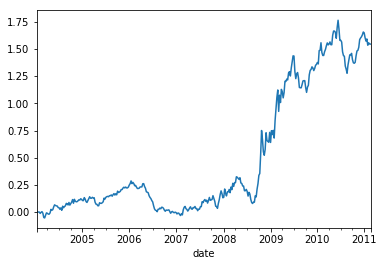

In [95]:
#plt.figsize(10, 3)
(np.exp(data.log_returns_new_data.cumsum()) - 1).plot();

Much worse. As seen before there is a qualitative difference between the search data used in Preis and the one that can be downloaded today. This might be expected since the signal is indeed degraded as you mentioned (only 72% of the order decisions match when comparing the two data sources).

Finally, lets see how well the strategy (using the Preis signals) would do on S&P500.

In [98]:
#plt.figsize(10, 3)
#(np.exp(data.log_returns_sp.cumsum()) - 1).plot();